In [69]:
# This cell is mandatory in all Dymos documentation notebooks.
missing_packages = []
try:
    import openmdao.api as om  # noqa: F401
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install openmdao[notebooks]
    else:
        missing_packages.append('openmdao')
try:
    import dymos as dm  # noqa: F401
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !python -m pip install dymos
    else:
        missing_packages.append('dymos')
try:
    import pyoptsparse  # noqa: F401
except ImportError:
    if 'google.colab' in str(get_ipython()):
        !pip install -q condacolab
        import condacolab
        condacolab.install_miniconda()
        !conda install -c conda-forge pyoptsparse
    else:
        missing_packages.append('pyoptsparse')
if missing_packages:
    raise EnvironmentError('This notebook requires the following packages '
                           'please install them and restart this notebook\'s runtime: {",".join(missing_packages)}')

# Zermelo's Problem with Desensitized Optimal Control

This example is a demonstration taken from the [this 2019 paper by Seywald and Seywald](https://arc.aiaa.org/doi/abs/10.2514/6.2019-0651). With desensitized optimal control, the jacobian matrix of sensitivities of the states with respect to the initial states are carried as an additional state variable. By augmenting the state vector with parameters, we can track the sensitivity of the final state with respect to variations in the parameter throughout the trajectory. This sensitivity can then by constrained or lumped into the objective to find the minimum cost subject to some robustness to uncertainties in the parameters.

# Use of Jax

This example takes advantage of OpenMDAO's `JaxExplicitComponent`, which makes it simple to build components and leverage the algorithmic differentiation (AD) capability of [Jax](https://github.com/jax-ml/jax) to provide the derivatives that would be rather tedious and time-consuming to do by hand.

Because the integration of the sensitivty matrix involves the derivatives of the nominal ODE, and then taking derivatives _again_ to get the derivatives for optimization, AD is extremely valuable in this example.

In [70]:
import scipy.sparse as sp
import numpy as np

import jax
import jax.numpy as jnp

import openmdao.api as om

import dymos as dm

jax.config.update("jax_enable_x64", True)

# Jax Functions

First we're going to define *functions* that we'll later call from our JaxExplicitComponent.  The first is our nominal ODE, `f_zermelo`.  Note that this function uses the `jax.numpy` package (imported as `jnp`) to perform its operations. In order for its AD to work, Jax requires that everything within a function be translatable into Jax internal language. If we used the standard numpy package here, we would break that "chain" of differentiablility and things would not work.

In addition to the nominal ODE, we want to be able to compute the jacobian matrix of `f_zermelo` (the derivatives of the outputs wrt the inputs). To accomplish that, we first define a function where all of the inputs and outputs are stacked into a single array.  Calling `jax.jacobian(f_zermelo_wrapped)` will then evaluate this jacobian matrix at a single point.  We then wrap _that_ function in a `jax.vmap(..., in_axes=(0,))` call.  This automatically vectorizes the jacobian function along the first dimension - and assuming you're familiar with dymos, you'll know that variables are vectorized such that the first dimension is the number of nodes at which we are evaluating the ODE.

All of these functions are differentiable via the AD capability of Jax.

In [71]:
def f_zermelo(x1, x2, c, u):
    x1_dot = jnp.cos(u) + c * x2
    x2_dot = jnp.sin(u)
    c_dot = jnp.zeros_like(c)
    return x1_dot, x2_dot, c_dot

# Define a wrapper for vectorized computation of outputs
def f_zermelo_wrapped(inputs):
    x1, x2, c, u = inputs.T
    return jnp.column_stack(f_zermelo(x1, x2, c, u))  # Use column_stack to handle batched outputs

# Compute the Jacobian of the function
jac_zermelo = jax.vmap(jax.jacobian(f_zermelo_wrapped), in_axes=(0,))  # Vectorized over the batch

# The Zermelo ODE

Zermelo's problem is a classic trajectory optimziation problem.  In this implementation, we're going to maximize the travel distance downstream by taking advantage of higher stream speeds in the middle of a navigable channel.

This code follows the example from the reference paper above. The state consists of two position coordinates (`x1` and `x2`), and the sensitivity of stream velocity with respect to distance from the channel's boundary (`c`). Control `u` dictates the direction of travel at any given time.

Additional state `S` is the sensitivity matrix. This tracks the sensitivity of the three other states with respect to their initial values.  Logically, at the initial time, the sensitivity of each state with respect to its initial value is `1` and the initial value of `S` is therefore an identity matrix. The integration of S just means accumulating the sensitivity of the nominal ODE with respect to the state vector along the way. In the 'closed-loop' formulation in the reference, we also accumulate the sensitivty with respect to the control multiplied by some gain `K`.

For those familiar with `dymos`, there are just a few features of this component that differ from a more typical ODE component.

Because we're using `JaxExplicitComponent` and we have an option or attribute that may impact the calculation, we have to use the `get_self_statics` method to return a tuple of these `static` variables. Internally, Jax will not provide derivatives with respect to these static parameters, since they're fixed throughout the optimization.

In `setup_partials`, we still need to provide the sparisty pattern of the outputs with respect to the inputs. Jax does not trace the inpact of every index of every input to every index of every output. For the derivatives with respect to the matrix state `S` and vector state `K`, we are overly conservative and assume that the entire $\dot{S}$ matrix at each node is impacted by every element of $S$ and every element of $K$. Still, the performance we get despite this conservatism is good.

Finally, the `compute_primal` method is the special "Jax-aware" method of `JaxExplicitComponent`. Unlike a typical `compute` method in OpenMDAO, we don't provide `inputs` as a dictionary but just provide every input as an argument, in the order which it was added during setup. And we return the outputs in the order in which they were added during setup.

That's it, no we have a component that's providing AD derivatives for dymos and we save ourselves a lot of time instead of tring to derive these derivatives analytically.

In [72]:
class ZermeloODE(om.JaxExplicitComponent):

    def initialize(self):
        """
        All Dymos ODE systems are required to have an option "num_nodes",
        which is the number of points at which the ODE is simultaneously evaluated.

        This will be set by the Phase during setup once the transcription details are known.
        """
        self.options.declare('num_nodes', types=(int,))

    def setup(self):
        """
        In setup, we add inputs and outputs.

        The first dimension is assumed to pertain to the index of the node.

        An input that's a scalar at each node should have a shape of
        (num_nodes, 1) or just (num_nodes,).

        For vectors or matrices, it's just the shape of the matrix at each
        node prepended with num_nodes.

        We provide units for the scalars, but OpenMDAO doesn't do unit conversion on an index-by-index basis,
        so we just assume that no unit conversion should be done for the S matrix and K vector.
        """
        nn = self.options['num_nodes']

        # ODE inputs
        self.add_input('x1', shape=(nn,), units='m')
        self.add_input('x2', shape=(nn,), units='m')
        self.add_input('c', shape=(nn,), units='1/s')
        self.add_input('u', shape=(nn,), units='rad')
        self.add_input('S', shape=(nn, 3, 3), units=None)
        self.add_input('K1', shape=(nn,), units=None)
        self.add_input('K2', shape=(nn,), units=None)
        self.add_input('K3', shape=(nn,), units=None)

        # State rates
        self.add_output('x1_dot', shape=(nn,), units='m/s', tags=['dymos.state_rate_source:x1'])
        self.add_output('x2_dot', shape=(nn,), units='m/s', tags=['dymos.state_rate_source:x2'])
        self.add_output('c_dot', shape=(nn,), units='1/s**2', tags=['dymos.state_rate_source:c'])
        self.add_output('S_dot', shape=(nn, 3, 3), units='1/s', tags=['dymos.state_rate_source:S'])

    # because our compute primal output depends on static variables, in this case
    # and self.options['num_noswa'], we must define a get_self_statics method. This method must
    # return a tuple of all static variables. Their order in the tuple doesn't matter.  If your
    # component happens to have discrete inputs, do NOT return them here. Discrete inputs are passed
    # into the compute_primal function individually, after the continuous variables.
    def get_self_statics(self):
        # return value must be hashable
        return self.options['num_nodes'],

    def setup_partials(self):
        nn = self.options['num_nodes']
        ar = jnp.arange(nn, dtype=int)
        self.declare_partials('x1_dot', 'x2', rows=ar, cols=ar)
        self.declare_partials('x1_dot', 'c', rows=ar, cols=ar)
        self.declare_partials('x1_dot', 'u', rows=ar, cols=ar)
        self.declare_partials('x2_dot', 'u', rows=ar, cols=ar)

        # S_dot is 3x3 at each node, so we expact 9 scalar nonzeros at each node for each "scaler at each node" input
        rs = jnp.arange(nn * 3 * 3, dtype=int)
        cs = jnp.repeat(jnp.arange(nn, dtype=int), 3 * 3)
        self.declare_partials('S_dot', ['x1', 'x2', 'c', 'u', 'K1', 'K2', 'K3'], rows=rs, cols=cs)

        # For S wrt S, we conservatively have a block diagonal of nn 9x9 blocks.
        rs, cs = sp.block_diag(nn * [np.ones((9, 9))]).nonzero()
        self.declare_partials('S_dot', 'S', rows=rs, cols=cs)

        # # For S wrt S, we conservatively have a block diagonal of nn 9x9 blocks.
        # rs, cs = sp.block_diag(nn * [np.ones((9, 3))]).nonzero()
        # self.declare_partials('S_dot', 'K', rows=rs, cols=cs)

    def compute_primal(self, x1, x2, c, u, S, K1, K2, K3):
        """
        This method does the "primal" computation in jax, and then OpenMDAO may
        differentiate it under-the-hood in order to get the partial derivatives
        through the component.

        Because we're using Jax's AD to get the derivatives here, everything within
        this method, and those functions it calls, need to be Jax-composed functions.
        """
        nn = self.options['num_nodes']
        vec_inputs = jnp.column_stack([x1, x2, c, u])

        # vec_outputs = f_zermelo_wrapped(vec_inputs)
        # x1_dot, x2_dot, c_dot = vec_outputs.T
        x1_dot, x2_dot, c_dot = f_zermelo(x1, x2, c, u)

        # The jacobian df_dxu is a 3x4 jacobian matrix at each node.
        df_dxu = jac_zermelo(vec_inputs).reshape((nn, 3, 4))

        df_dx = df_dxu[:, :, :-1] # Extract the sensitivities wrt x.
        df_du = df_dxu[:, :, -1:] # Extract the sensitivities wrt u.

        # Just matmult to get a matrix-matrix product at each node
        # Stack K's to get expected (1, 3) shape at each node.abs
        _K = jnp.reshape(jnp.vstack((K1, K2, K3)).T,(nn, 1, 3))
        S_dot = jnp.matmul(df_dx, S) + jnp.matmul(df_du, _K)

        return x1_dot, x2_dot, c_dot, S_dot

# Defining the Open Loop Problem

In this example, we use the above ODE and solve the nominal Zermelo optimal control problem. The sensitivity matrix is integrated, but has no impact on the solution. It's just "along for the ride" so to speak.

In [73]:
def solve_zermelo_open_loop(matrix_free=False, num_segments=20):

    # Create a standard OpenMDAO problem.
    p = om.Problem(name='zermelo_open_loop')

    # Trajectory is a special OpenMDAO Group defined by dymos.
    traj = dm.Trajectory()

    # The transcription, which defines how to convert the continuous optimal control
    # problem into a discrete NLP problem.
    # This contains things like informatino regarding the grid segmentation, and
    # defines what specific OpenMDAO systems are needed for the numerics.
    tx = dm.Radau(num_segments=num_segments, order=3)

    # Add a Phase to the trajectory.
    # Phase is also a special OpenMDAO Group defined by dymos which combines
    # the ODE system and the transcription.
    phase = traj.add_phase('phase', dm.Phase(ode_class=ZermeloODE,
                                             transcription=tx))

    # Set the time options in the phase. (Whether the initial value and final value are fixed, the time units)
    phase.set_time_options(fix_initial=True, fix_duration=True, units='s')

    # The options for each of our state variables.
    # OpenMDAO does unit conversions internally.  The units defined here are the units
    # in which the design variables of the optimizer are defined.
    phase.set_state_options('x1', fix_initial=True, fix_final=False, units='m')
    phase.set_state_options('x2', fix_initial=True, fix_final=True, units='m')
    phase.set_state_options('c', fix_initial=True, fix_final=False, units='1/s')
    phase.set_state_options('S', fix_initial=True, fix_final=False, units=None)

    # Tell dymos that 'u' is a dynamic control variable. Control variable discretization node
    # values are design variables by default (option `opt=True``)
    phase.add_control('u', units='rad', lower=-np.pi/2, upper=np.pi/2)
    phase.add_control('K1', units=None, opt=False)
    phase.add_control('K2', units=None, opt=False)
    phase.add_control('K3', units=None, opt=False)

    # Add the trajectory group to our OpenMDAO model.
    p.model.add_subsystem('traj', traj)

    # Add an optimization driver to the problem.
    # For this problem, ScipyOptimizeDriver (which uses scipy SLSQP by default) is fine.
    # p.driver = om.ScipyOptimizeDriver()
    p.driver = om.pyOptSparseDriver(optimizer='IPOPT')
    p.driver.opt_settings['print_level'] = 5
    p.driver.opt_settings['mu_init'] = 1e-3
    # p.driver.opt_settings['max_iter'] = 500
    # p.driver.opt_settings['acceptable_tol'] = 1e-5
    # p.driver.opt_settings['constr_viol_tol'] = 1e-6
    # p.driver.opt_settings['compl_inf_tol'] = 1e-6
    p.driver.opt_settings['tol'] = 1e-5
    p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'  # for faster convergence
    # p.driver.opt_settings['alpha_for_y'] = 'safer-min-dual-infeas'
    p.driver.opt_settings['mu_strategy'] = 'monotone'
    p.driver.opt_settings['bound_mult_init_method'] = 'mu-based'

    # Use an automated graph "coloring" algorithm to determine how to most efficiently
    # compute the total derivatives for the optimizer.
    p.driver.declare_coloring()

    # Tell the phase that x1 is our objective, and that we are maximizing it.
    # ref is the value that the optimizer sees as 1.0.
    # A negative sign means we are minimizing the negative.
    phase.add_objective('x1', ref=-1.0)

    # Call setup, which is a bit analogous to "compiling" the model in OpenMDAO.
    # OpenMDAO will determine all connections for data in the model, allocate memory, etc.
    p.setup()

    # The set_***_val methods on dymos phases allow us to provide values
    # for times, states, controls, and parameters.
    # States and controls are interpolated, linearly by default, from the first value at the start
    # of the phase, to the second value at the end of the phase.
    # If we fixed the initial or final values, then these are the initial or final values that will
    # be set and not changed while solving the problem.
    phase.set_time_val(initial=0.0, duration=1.0)
    phase.set_state_val('x1', vals=[0.0, 1])
    phase.set_state_val('x2', vals=[0, 0])
    phase.set_state_val('c', vals=[10, 10])

    # S is initially an identity matrix at each node. We interpolate this to be constant throughout the phase
    # as the initial guess.
    S0 = jnp.eye(3)
    phase.set_state_val('S', [S0, S0])

    # K = jnp.zeros((3,))
    # phase.set_control_val('K', vals=[K, K])
    phase.set_control_val('K1', vals=[0, 0])
    phase.set_control_val('K2', vals=[0, 0])
    phase.set_control_val('K3', vals=[0, 0])

    # Control u is interpolated as 0 across the phase as the initial guess.
    phase.set_control_val('u', vals=[0, 0])

    # The run_problem function in dymos runs an OpenMDAO problem that involves dymos.
    # The simulate argument means that we will explicitly integrate the final control solution
    # as an IVP so that we can see how the implicit solution compares to the explicit simulation.
    # Make plots will automatically generate plots in zermelo_open_loop_out/reports/traj_results.
    dm.run_problem(p, simulate=True, make_plots=True)

    return p

In [74]:
zermelo_prob = solve_zermelo_open_loop(num_segments=10)

/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/problem.py:355: OpenMDAOWarning:The problem name 'zermelo_open_loop' already exists
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'scaling' for instance 'zermelo_open_loop.driver' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'total_coloring' for instance 'zermelo_open_loop.driver' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'n2' for instance 'zermelo_open_loop' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'optimizer' for instance 'zermelo_open_loop' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'inputs' for instance 'zermelo_open_loop' is already 


--- Constraint Report [traj] ---
    --- phase ---
        None

Full total jacobian for problem 'zermelo_open_loop' was computed 3 times, taking 0.672718791058287 seconds.
Total jacobian shape: (379, 389) 


Jacobian shape: (379, 389)  (3.22% nonzero)
FWD solves: 45   REV solves: 0
Total colors vs. total size: 45 vs 389  (88.43% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity:   0.6727 sec
Time to compute coloring:   0.2270 sec
Memory to compute coloring:   0.8906 MB
Coloring created on: 2024-12-16 12:38:21

List of user-set options:

                                    Name   Value                used
                  bound_mult_init_method = mu-based              yes
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = mumps                 yes
                                 mu_init = 0.001                 yes
           

/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/group.py:1166: DerivativesWarning:Constraints or objectives [ode_eval.control_interp.control_rates:K1_rate, ode_eval.control_interp.control_rates:K1_rate2, ode_eval.control_interp.control_rates:K2_rate, ode_eval.control_interp.control_rates:K2_rate2, ode_eval.control_interp.control_rates:K3_rate, ode_eval.control_interp.control_rates:K3_rate2, ode_eval.control_interp.control_rates:u_rate, ode_eval.control_interp.control_rates:u_rate2, ode_eval.control_interp.control_values:K1, ode_eval.control_interp.control_values:K2, ode_eval.control_interp.control_values:K3, ode_eval.control_interp.control_values:u] cannot be impacted by the design variables of the problem because no partials were defined for them in their parent component(s).



Simulating trajectory traj
Done simulating trajectory traj


In [75]:
x1 = zermelo_prob.get_val('traj.phase.timeseries.x1')
x2 = zermelo_prob.get_val('traj.phase.timeseries.x2')
t = zermelo_prob.get_val('traj.phase.timeseries.time')
c = zermelo_prob.get_val('traj.phase.timeseries.c')
u = zermelo_prob.get_val('traj.phase.timeseries.u')
S = zermelo_prob.get_val('traj.phase.timeseries.S')

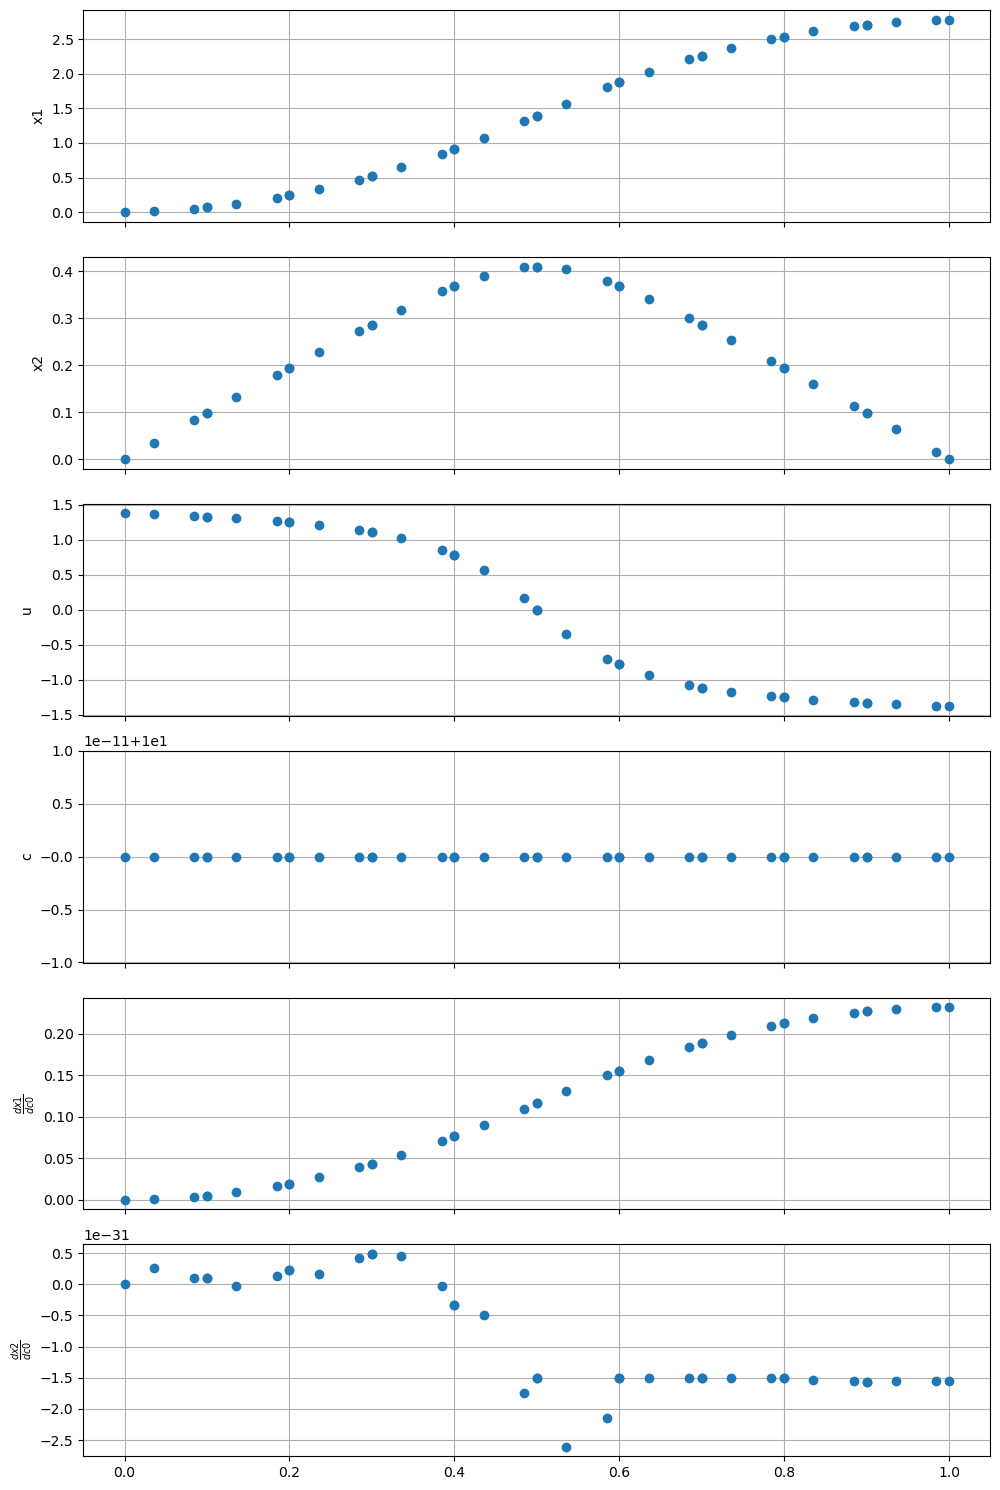

array([[ 1.00000000e+00,  1.00000000e+01,  2.31823573e-01],
       [-1.70119782e-42,  1.00000000e+00, -1.54825257e-31],
       [ 1.19420347e-43,  2.32590334e-34,  1.00000000e+00]])

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True)
axes[0].plot(t, x1, 'o')
axes[0].grid()
axes[0].set_ylabel('x1')

axes[1].plot(t, x2, 'o')
axes[1].grid()
axes[1].set_ylabel('x2')

axes[2].plot(t, u, 'o')
axes[2].grid()
axes[2].set_ylabel('u')

axes[3].plot(t, c, 'o')
axes[3].grid()
axes[3].set_ylabel('c')

S_labels = {(0, 2): r'$\frac{dx1}{dc0}$',
            (1, 2): r'$\frac{dx2}{dc0}$'}

a_i = 4
for s_i in [0, 1]:
    for s_j in [2]:
        axes[a_i].plot(t, S[:, s_i, s_j], 'o')
        axes[a_i].grid()
        axes[a_i].set_ylabel(S_labels[s_i, s_j])
        a_i += 1
plt.tight_layout()
plt.show()

S[-1, ...]


# Solving the Closed Loop form of the Desensitized Optimal Control Problem

Term $S$ represents the sensitivity of the states x at any given point wrt the initial state.

\begin{align}
S &= \frac{dx}{dx_0}
\end{align}

Therefore at the final time,

\begin{align}
S(t_f) &= \frac{dx_f}{dx_0}
\end{align}

Inverting S(t), we get

\begin{align}
S^{-1}(t) &= \frac{dx_0}{dx}
\end{align}

Therefore, we can obtain the sensitivities due to perturbations
along the trajectory (not just the initial states), using

\begin{align}
S(t_f)S^{-1}(t) &= \frac{dx_f}{dx_0} \frac{dx_0}{dx} = \frac{dx_f}{dx}
\end{align}

We can integrate this term to obtain a total "drift" in a state due to uncertainties along the way.

Collocation techniques are particularly useful here because we always have an estimate for $S(t_f)$.

Furthermore, we don't need to treat $S(t_f)S^{-1}(t)$ as an integrated state. We have the S matrix at all points, which we can invert at all points, multiply by S at the final point, and then use an explicit quadrature to obtain its integral.

And for efficiency, we can determine the sensitivity $\frac{dx_f}{dx}$ using a linear solve rather than actually inverting the $S$ matrix at each node in the trajectory.

\begin{align}
    S(t_f)S^{-1}(t) &= \left[ \frac{dx_f}{dx} \right] \\
    S(t_f) &= \left[ \frac{dx_f}{dx} \right] S(t) \\
\end{align}

So therefore at each node $i$ in the trajectory we have the linear solve

\begin{align}
    \left[ \frac{dx_f}{dx_i} \right]^T = \mathrm{solve}(S_i^T, S_f^T)
\end{align}

# More Jax Functions for the composite objective.

To compute our quadrature, we're going to need node weights from the interpolating polynomials. When we run this next problem, we have to use the same transcription as the open loop problem in order for these weights to be applicable.

In [77]:
# Need to update dymos to save the node weights in GridData
w = zermelo_prob.model.traj.phases.phase.options['transcription'].grid_data.node_weight

def quadrature(f, dt_dstau):
    _w = w.reshape((-1,) + (1,) * (len(f.shape) - 1))
    _dt_dstau = dt_dstau.reshape((-1,) + (1,) * (len(f.shape) - 1))
    return jnp.sum(_dt_dstau * _w * f, axis=0)

The `solve_right` function enables us to solve the linear system above.  Note the use of `vmap` again to get a differentiable solve of this system at each node.

In [78]:
def solve_right(A, B):
    """
    Solves for X in batched systems X @ A = B.

    Parameters:
    A: jnp.ndarray, shape (batch_size, m, m)
        The square matrices on the right side of the equation.
    B: jnp.ndarray, shape (m, m)
        The right-hand side tensors.

    Returns:
    X: jnp.ndarray, shape (batch_size, m, m)
        The solution tensors.
    """
    B_T = jnp.transpose(B)
    def solve_single(A_single):
        A_T = jnp.transpose(A_single)
        X_T = jnp.linalg.solve(A_T, B_T)
        return jnp.transpose(X_T)

    # Use vmap over the batch dimension of A only
    solve_batched = jax.vmap(solve_single, in_axes=0, out_axes=0)
    return solve_batched(A)

# The Closed Loop Objective

The closed loop objectivekes in the nominal objective (`x1_f`) and adds it to a penalty on the sensitivities `dxf_dx` ($S(t_f)S^{-1}(t)$) as well as a penalty on the gains `K`.  This component outputs a single scalar, so the partials are all just dense columns. Furthermore, we're going to make use of OpenMDAO's `shape_by_conn` capability here so that we don't need to know the number of nodes that apply to `S` and `K`.

We're just going to drop this comonponent into the model after our trajectory, hook up the necessary inputs, and tell OpenMDAO to use its output `J` as our objective.  We will _not_ be using the `add_objective` method of a dymos Phase in this case.

In [79]:
class ObjectiveComp(om.JaxExplicitComponent):

    def setup(self):
        """
        In setup, we add inputs and outputs.

        The first dimension is assumed to pertain to the index of the node.

        An input that's a scalar at each node should have a shape of
        (num_nodes, 1) or just (num_nodes,).

        For vectors or matrices, it's just the shape of the matrix at each
        node prepended with num_nodes.

        We provide units for the scalars, but OpenMDAO doesn't do unit conversion on an index-by-index basis,
        so we just assume that no unit conversion should be done for the S matrix and K vector.
        """
        # nn = self.options['num_nodes']

        # Inputs
        self.add_input('q', val=0.0, units=None)
        self.add_input('r', val=1.0, units=None)
        self.add_input('S', shape_by_conn=True, units=None)
        self.add_input('K1', shape_by_conn=True, units=None)
        self.add_input('K2', shape_by_conn=True, units=None)
        self.add_input('K3', shape_by_conn=True, units=None)
        self.add_input('x1_f', shape=(1,), units=None)
        self.add_input('dt_dstau', shape_by_conn=True, units=None)

        # Outputs
        self.add_output('J', val=1.0, units=None)

    def setup_partials(self):
        # J is a function of all inputs
        # J is a scalar so we don't need to specify the sparsity.
        self.declare_partials('J', ['*'])

    def compute_primal(self, q, r, S, K1, K2, K3, x1_f, dt_dstau):
        """
        This method does the "primal" computation in jax, and then OpenMDAO may
        differentiate it under-the-hood in order to get the partial derivatives
        through the component.

        Because we're using Jax's AD to get the derivatives here, everything within
        this method, and those functions it calls, need to be Jax-composed functions.
        """
        S_f = S[-1, ...]
        dxf_dx = solve_right(S, S_f)

        J1 = quadrature(q * (dxf_dx[:, 0, 2][:, jnp.newaxis]**2 + dxf_dx[:, 1, 2][:, jnp.newaxis]**2),
                        dt_dstau)
        J2 = quadrature(r * (K1[:, jnp.newaxis]**2 + K2[:, jnp.newaxis]**2 + K3[:, jnp.newaxis]**2),
                        dt_dstau)

        return -x1_f + J1 + J2

# Now lets build the model again with our objective in the loop.

In [88]:
def solve_zermelo_closed_loop(q=0.0, r=1.0, run_driver=False):

    # Create a standard OpenMDAO problem.
    p = om.Problem(name='zermelo_closed_loop')

    # Trajectory is a special OpenMDAO Group defined by dymos.
    traj = dm.Trajectory()

    # The transcription, which defines how to convert the continuous optimal control
    # problem into a discrete NLP problem.
    # This contains things like informatino regarding the grid segmentation, and
    # defines what specific OpenMDAO systems are needed for the numerics.
    tx = dm.Radau(num_segments=10, order=3)

    # Add a Phase to the trajectory.
    # Phase is also a special OpenMDAO Group defined by dymos which combines
    # the ODE system and the transcription.
    phase = traj.add_phase('phase', dm.Phase(ode_class=ZermeloODE, transcription=tx))

    # Set the time options in the phase. (Whether the initial value and final value are fixed, the time units)
    phase.set_time_options(fix_initial=True, fix_duration=True, units='s')

    # The options for each of our state variables.
    # OpenMDAO does unit conversions internally.  The units defined here are the units
    # in which the design variables of the optimizer are defined.
    phase.set_state_options('x1', fix_initial=True, fix_final=False, units='m', lower=0)
    phase.set_state_options('x2', fix_initial=True, fix_final=True, units='m', lower=0)
    phase.set_state_options('c', fix_initial=True, fix_final=False, units='1/s')
    phase.set_state_options('S', fix_initial=True, fix_final=False, units=None)

    # Tell dymos that 'u' is a dynamic control variable. Control variable discretization node
    # values are design variables by default (option `opt=True``)

    K1_lb, K1_ub = -0.15, 0.15
    K2_lb, K2_ub = -0.004, 0.004
    phase.add_control('u', units='rad', lower=-np.pi/2, upper=np.pi/2)
    phase.add_control('K1', units=None, opt=True, lower=K1_lb, upper=K1_ub)
    phase.add_control('K2', units=None, opt=True, lower=K2_lb, upper=K2_ub)
    phase.add_control('K3', units=None, opt=False)

    # Add the trajectory group to our OpenMDAO model.
    p.model.add_subsystem('traj', traj)

    # Add the objective calculation
    obj_comp = p.model.add_subsystem('obj_comp', ObjectiveComp())

    p.model.connect('traj.phase.timeseries.S', 'obj_comp.S')
    p.model.connect('traj.phase.timeseries.K1', 'obj_comp.K1')
    p.model.connect('traj.phase.timeseries.K2', 'obj_comp.K2')
    p.model.connect('traj.phase.timeseries.K3', 'obj_comp.K3')
    p.model.connect('traj.phase.timeseries.x1', 'obj_comp.x1_f', src_indices=om.slicer[-1, ...])
    p.model.connect('traj.phase.dt_dstau', 'obj_comp.dt_dstau')

    # Add an optimization driver to the problem.
    # For this problem, ScipyOptimizeDriver (which uses scipy SLSQP by default) is fine.
    p.driver = om.pyOptSparseDriver(optimizer='IPOPT')
    p.driver.opt_settings['print_level'] = 5
    p.driver.opt_settings['mu_init'] = 1e-3
    # p.driver.opt_settings['max_iter'] = 500
    # p.driver.opt_settings['acceptable_tol'] = 1e-5
    # p.driver.opt_settings['constr_viol_tol'] = 1e-6
    # p.driver.opt_settings['compl_inf_tol'] = 1e-6
    p.driver.opt_settings['tol'] = 1e-5
    p.driver.opt_settings['nlp_scaling_method'] = 'gradient-based'  # for faster convergence
    # p.driver.opt_settings['alpha_for_y'] = 'safer-min-dual-infeas'
    p.driver.opt_settings['mu_strategy'] = 'monotone'
    p.driver.opt_settings['bound_mult_init_method'] = 'mu-based'
    
    # Use an automated graph "coloring" algorithm to determine how to most efficiently
    # compute the total derivatives for the optimizer.
    p.driver.declare_coloring()

    # Now we're no longer adding the objecitve to an output of the phase itself, but
    # a downstream calculation of the objective.
    obj_comp.add_objective('J', ref=-1.0)

    # Call setup, which is a bit analogous to "compiling" the model in OpenMDAO.
    # OpenMDAO will determine all connections for data in the model, allocate memory, etc.
    p.setup()

    # The set_***_val methods on dymos phases allow us to provide values
    # for times, states, controls, and parameters.
    # States and controls are interpolated, linearly by default, from the first value at the start
    # of the phase, to the second value at the end of the phase.
    # If we fixed the initial or final values, then these are the initial or final values that will
    # be set and not changed while solving the problem.
    phase.set_time_val(initial=0.0, duration=1.0)
    phase.set_state_val('x1', vals=[0.0, 1])
    phase.set_state_val('x2', vals=[0, 0])
    phase.set_state_val('c', vals=[10, 10])

    # S is initially an identity matrix at each node. We interpolate this to be constant throughout the phase
    # as the initial guess.
    S0 = jnp.eye(3)
    phase.set_state_val('S', [S0, S0])

    phase.set_control_val('K1', vals=0.0)
    phase.set_control_val('K2', vals=0.0)
    phase.set_control_val('K3', vals=0.0)

    # Control u is interpolated as 0 across the phase as the initial guess.
    phase.set_control_val('u', vals=[0, 0])

    p.set_val('obj_comp.q', q)
    p.set_val('obj_comp.r', r)

    # The run_problem function in dymos runs an OpenMDAO problem that involves dymos.
    # The simulate argument means that we will explicitly integrate the final control solution
    # as an IVP so that we can see how the implicit solution compares to the explicit simulation.
    # Make plots will automatically generate plots in zermelo_doc_out/reports/traj_results.
    dm.run_problem(p, run_driver=run_driver, simulate=True, make_plots=True)

    return p

In [96]:
zermelo_closed_loop_prob = solve_zermelo_closed_loop(q=50, r=10, run_driver=True)

/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/problem.py:355: OpenMDAOWarning:The problem name 'zermelo_closed_loop' already exists
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'scaling' for instance 'zermelo_closed_loop.driver' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'total_coloring' for instance 'zermelo_closed_loop.driver' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'n2' for instance 'zermelo_closed_loop' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'optimizer' for instance 'zermelo_closed_loop' is already active.
/Users/rfalck/Codes/OpenMDAO.git/openmdao/utils/reports_system.py:277: OpenMDAOWarning:A report with the name 'inputs' for instance 'zermelo_closed_loop'


--- Constraint Report [traj] ---
    --- phase ---
        None

Full total jacobian for problem 'zermelo_closed_loop' was computed 3 times, taking 0.891000916948542 seconds.
Total jacobian shape: (415, 449) 


Jacobian shape: (415, 449)  (3.11% nonzero)
FWD solves: 0   REV solves: 47
Total colors vs. total size: 47 vs 415  (88.67% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity:   0.8910 sec
Time to compute coloring:   0.3579 sec
Memory to compute coloring:   1.1719 MB
Coloring created on: 2024-12-16 12:45:41

List of user-set options:

                                    Name   Value                used
                  bound_mult_init_method = mu-based              yes
                        file_print_level = 5                     yes
                   hessian_approximation = limited-memory        yes
                           linear_solver = mumps                 yes
                                 mu_init = 0.001                 yes
         

/Users/rfalck/Codes/OpenMDAO.git/openmdao/core/group.py:1166: DerivativesWarning:Constraints or objectives [ode_eval.control_interp.control_rates:K1_rate, ode_eval.control_interp.control_rates:K1_rate2, ode_eval.control_interp.control_rates:K2_rate, ode_eval.control_interp.control_rates:K2_rate2, ode_eval.control_interp.control_rates:K3_rate, ode_eval.control_interp.control_rates:K3_rate2, ode_eval.control_interp.control_rates:u_rate, ode_eval.control_interp.control_rates:u_rate2, ode_eval.control_interp.control_values:K1, ode_eval.control_interp.control_values:K2, ode_eval.control_interp.control_values:K3, ode_eval.control_interp.control_values:u] cannot be impacted by the design variables of the problem because no partials were defined for them in their parent component(s).
/Users/rfalck/Codes/OpenMDAO.git/openmdao/recorders/sqlite_recorder.py:230: UserWarning:The existing case recorder file, /Users/rfalck/Projects/dymos.git/dymos/examples/zermelo_doc/zermelo_closed_loop_out/traj_sim


Simulating trajectory traj
Done simulating trajectory traj


In [97]:
x1_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.x1')
x2_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.x2')
t_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.time')
c_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.c')
u_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.u')
S_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.S')
K1_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.K1')
K2_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.K2')
K3_cl = zermelo_closed_loop_prob.get_val('traj.phase.timeseries.K3')
K_cl = K1_cl, K2_cl, K3_cl

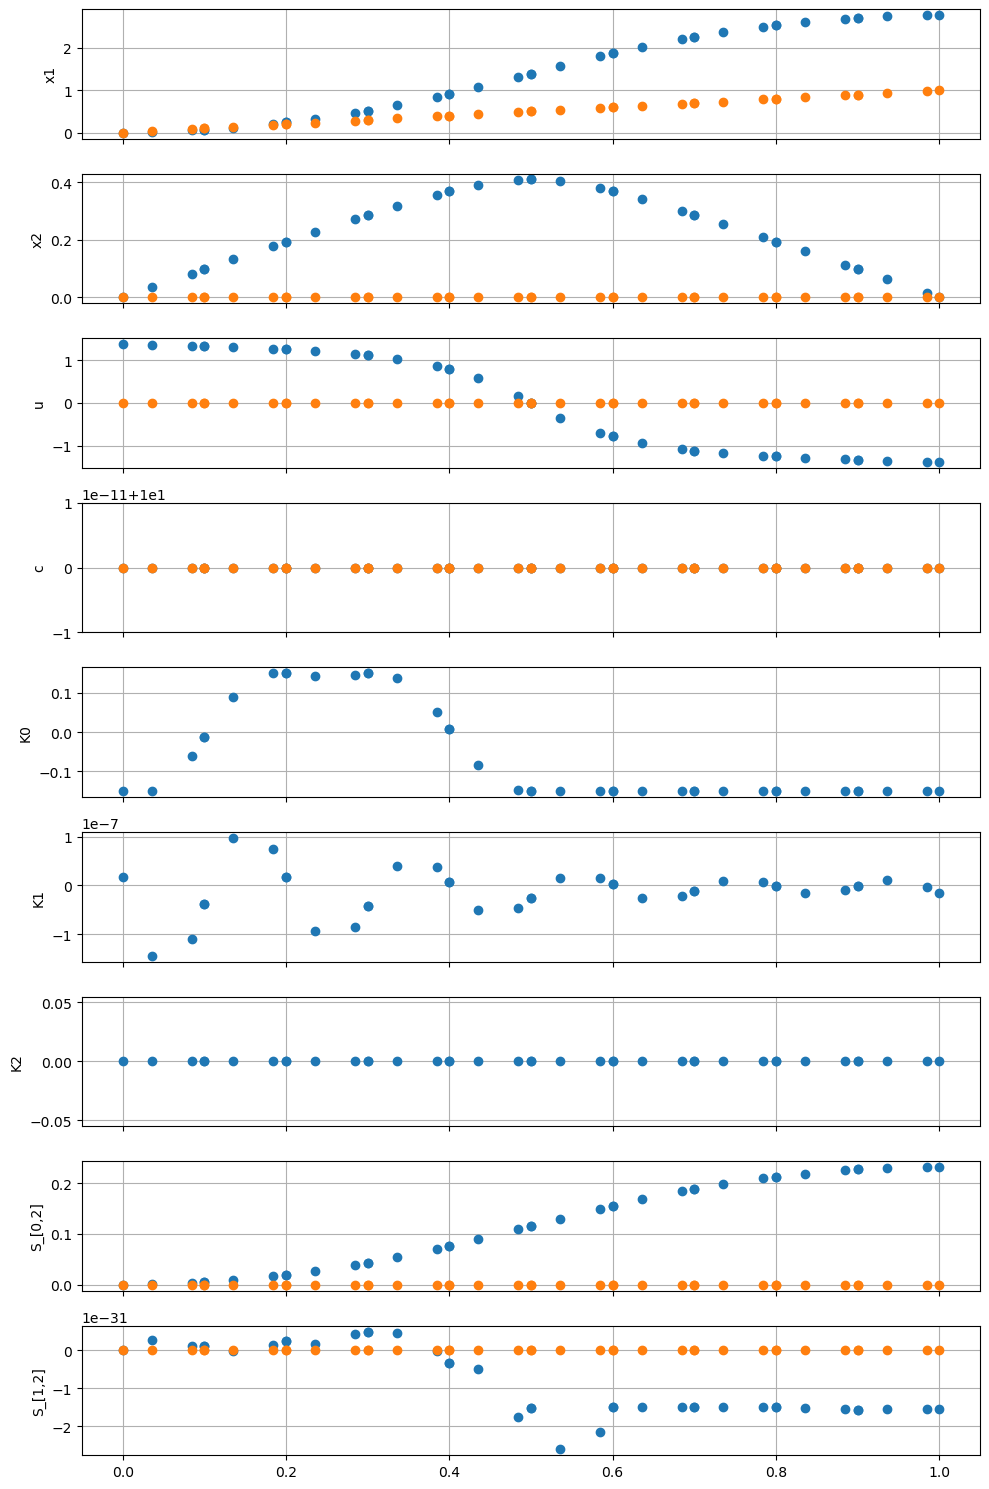

In [98]:
fig, axes = plt.subplots(9, 1, figsize=(10, 15), sharex=True)
axes[0].plot(t, x1, 'o')
axes[0].plot(t_cl, x1_cl, 'o')
axes[0].grid()
axes[0].set_ylabel('x1')

axes[1].plot(t, x2, 'o')
axes[1].plot(t_cl, x2_cl, 'o')
axes[1].grid()
axes[1].set_ylabel('x2')

axes[2].plot(t, u, 'o')
axes[2].plot(t_cl, u_cl, 'o')
axes[2].grid()
axes[2].set_ylabel('u')

axes[3].plot(t, c, 'o')
axes[3].plot(t_cl, c_cl, 'o')
axes[3].grid()
axes[3].set_ylabel('c')

a_i = 4
for i in range(3):
    axes[a_i].plot(t_cl, K_cl[i], 'o')
    # axes[a_i].plot(t_cl, c_cl, 'o')
    axes[a_i].grid()
    axes[a_i].set_ylabel(f'K{i}')
    a_i += 1

a_i = 7
for s_i in [0, 1]:
    for s_j in [2]:
        axes[a_i].plot(t, S[:, s_i, s_j], 'o')
        axes[a_i].plot(t_cl, S_cl[:, s_i, s_j], 'o')
        axes[a_i].grid()
        axes[a_i].set_ylabel(f'S_[{s_i},{s_j}]')
        a_i += 1
plt.tight_layout()


Text(0, 0.5, 'c')

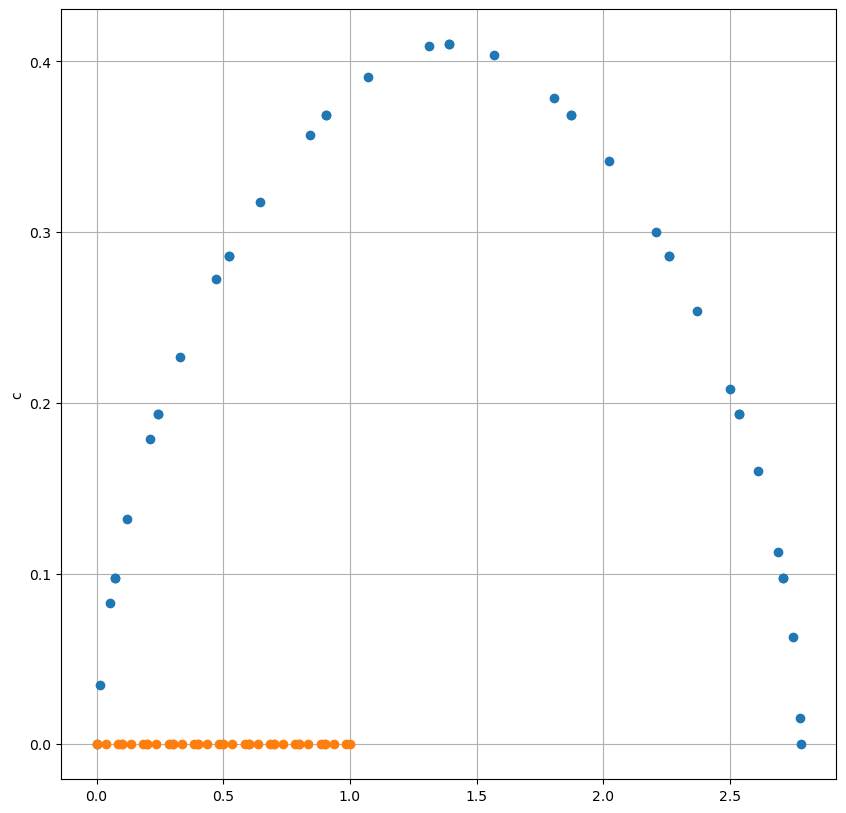

In [99]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(x1, x2, 'o')
ax.plot(x1_cl, x2_cl, 'o')
ax.grid()
ax.set_ylabel('c')

In [100]:
S_cl[-1, ...]

array([[ 9.12651274e-01,  9.99999989e+00,  2.62650872e-06],
       [-6.10508748e-02,  9.99999986e-01, -2.66728865e-34],
       [-2.52718266e-36, -4.34323855e-41,  1.00000000e+00]])

In [101]:
S[-1, ...]

array([[ 1.00000000e+00,  1.00000000e+01,  2.31823573e-01],
       [-1.70119782e-42,  1.00000000e+00, -1.54825257e-31],
       [ 1.19420347e-43,  2.32590334e-34,  1.00000000e+00]])